In [129]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import random
from keras.callbacks import EarlyStopping, TensorBoard
from keras.layers import Dense
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

In [3]:
file = open("audit_risk.csv", "r")
reader = csv.reader(file)
row = list(reader)[1:-1]
dataset = []
for x in row:
    r = []
    for y in x:
        r.append(float(y))
    dataset.append(r)
labelset = []
for i in dataset:
        labelset.append(i[-1])
file.close
class1 = []
class2 = []
for i in range(len(dataset)):
    if labelset[i] == 0:
        class1.append(dataset[i])
    elif labelset[i] == 1:
        class2.append(dataset[i])
l1 = len(class1)
l2 = len(class2)
if l1 >= l2:
    for i in range(0, l1 - l2):
        if np.random.random() > 0.003:
            class2.append(class2[np.random.randint(0, l2)][:-1]+[1])
        else:
            class2.append(class1[np.random.randint(0, l1)][:-1]+[0])
elif l1 < l2:
    for i in range(0, l2 - l1):
        if np.random.random() > 0.003:
            class1.append(class1[np.random.randint(0, l1)][:-1]+[0])
        else:
            class1.append(class2[np.random.randint(0, l2)][:-1]+[1])
data = class1 + class2
accuracy1 = np.zeros(4)
accuracy2 = np.zeros(4)
tp0 = 0
fp0 = 0
fn0 = 0
tn0 = 0
for n in range(10):
    np.random.shuffle(data)
    data1 = []
    label1 = []
    for i in data:
        data1.append(i[0:len(i)-1])
        label1.append(i[-1])
    dataset1 = data1[0:700]
    labelset1 = label1[0:700]
    dataset2 = data1[700:1000]
    labelset2 = label1[700:1000]

In [115]:
def sigmoid(x):
    return 1/(1 + np.exp(-x)) 

def relu(x):
    return np.maximum(0, x)

def forward(x, w, activation):
    return activation(np.matmul(x, w))

def accuracy_fn(y, y_hat):
    tp = 0
    fp = 0
    fn = 0
    tn = 0
    for i in range(y_hat.size):
        if y[i] == 1 and y_hat[i] == 1:
            tp = tp + 1
        elif y[i] == 1 and y_hat[i] == 0:
            fn = tn + 1
        elif y[i] == 0 and y_hat[i] == 1:
            fp = fp + 1
        elif y[i] == 0 and y_hat[i] == 0:
            tn = tn + 1
    return (tp+tn)/(y_hat.size)

def predict(x, y_hat, weights, activation):
    predictions = np.zeros(shape=(x.shape[0]))
    
    for idx in range(x.shape[0]):
        r1 = x[idx, :]
        for curr_weights in weights:
            r1 = forward(r1, curr_weights, activation)
        if r1 > 0.5:
            predictions[idx] = 1
    accuracy = accuracy_fn(predictions, y_hat)
    return accuracy, predictions
    
def fitness(x, y_hat, weights, activation):
    accuracy = np.empty(shape=(weights.shape[0]))
    for idx in range(weights.shape[0]):
        accuracy[idx], _ = predict(x, y_hat, weights[idx, :], activation)
    return accuracy

def conf_mat(x, y_hat, weights, activation):
    predictions = np.zeros(shape=(x.shape[0]))
    tp = 0
    fp = 0
    fn = 0
    tn = 0
    for idx in range(x.shape[0]):
        r1 = x[idx, :]
        for curr_weights in weights:
            r1 = forward(r1, curr_weights, activation)
        if r1 > 0.5:
            predictions[idx] = 1
    for i in range(y_hat.size):
        if predictions[i] == 1 and y_hat[i] == 1:
            tp = tp + 1
        elif predictions[i] == 1 and y_hat[i] == 0:
            fn = fn + 1
        elif predictions[i] == 0 and y_hat[i] == 1:
            fp = fp + 1
        elif predictions[i] == 0 and y_hat[i] == 0:
            tn = tn + 1
    return tp, fn, fp, tn

In [5]:
def mat_to_vector(mat_pop_weights):
    weights_vector = []
    for idx in range(mat_pop_weights.shape[0]):
        curr_vector = []
        for layer_idx in range(mat_pop_weights.shape[1]):
            vector_weights = np.reshape(mat_pop_weights[idx, layer_idx], newshape=(mat_pop_weights[idx, layer_idx].size))
            curr_vector.extend(vector_weights)

        weights_vector.append(curr_vector)
    return np.array(weights_vector)


def vector_to_mat(vector_weights, mat_pop_weights):
    mat_weights = []
    for idx in range(mat_pop_weights.shape[0]):
        start = 0
        end = 0
        for layer_idx in range(mat_pop_weights.shape[1]):
            end = end + mat_pop_weights[idx, layer_idx].size
            curr_vector = vector_weights[idx, start:end]
            mat_layer_weights = np.reshape(curr_vector, newshape=(mat_pop_weights[idx, layer_idx].shape))
            mat_weights.append(mat_layer_weights)
            start = end
    return np.reshape(mat_weights, newshape=mat_pop_weights.shape)

def weight_vector_to_mat(vector_weights, mat_weights):
    mat_weight = []
    start = 0
    end = 0
    for layer_idx in range(mat_weights.shape[0]):
        end = end + mat_weights[layer_idx].size
        curr_vector = vector_weights[start:end]
        mat_layer_weights = np.reshape(curr_vector, newshape=(mat_weights[layer_idx].shape))
        #print(mat_layer_weights)
        mat_weight.append(mat_layer_weights)
        start = end
    return np.reshape(mat_weight, newshape=mat_weights.shape)

In [46]:
def roulett(vec):
    r = np.random.uniform(0, np.sum(vec))
    s = 0
    for i,v in enumerate(vec):
        s += v
        if s>r:
            return i
    return len(vec)-1

In [83]:
N = 20 # number of population
T = 1000 #iteration time
c1 = c2 = 2
w_max = 0.9
w_min = 0.4 
x_max = 5
x_min = -5
v_max = 1 
v_min = -1 

mix_ratio = 0.75
smp = 5
cdc = 0.65
srd = 0.25

S = 2

num_generations = 10

input_shape = np.array(dataset1).shape[1]
print(input_shape)

26


  0%|          | 0/10 [00:00<?, ?it/s]

最优值为 0.8971428571428571 最优位置为 [  4.79466863   0.46832628   0.6503294  ... -13.84445594  13.51683301
  -8.39221372]


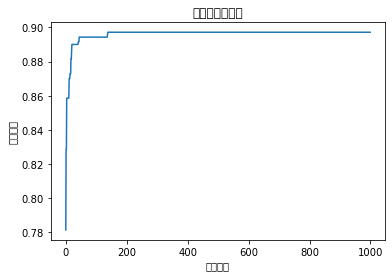

最优值为 0.9328571428571428 最优位置为 [ 8.10711431e-11 -1.53715148e-08 -1.86379457e-06 ... -5.97571761e-01
  2.57133921e+00 -2.34241406e+00]


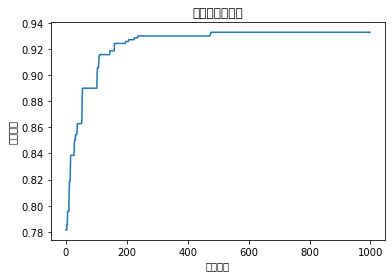

最优值为 0.7985714285714286 最优位置为 [-1.92746398e-05  3.20044849e-07 -1.37380064e-03 ... -1.14059129e-02
  2.38789204e+00 -3.92447597e+00]


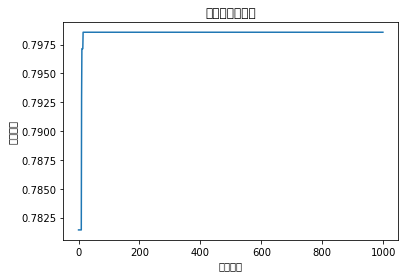

 10%|█         | 1/10 [12:35<1:53:23, 755.96s/it]

最优值为 0.9485714285714286 最优位置为 [-2.27919949 -1.20199596  1.31684319 ... -2.30568619 44.56905505
  2.38793284]


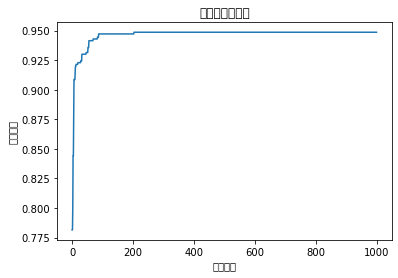

最优值为 0.9628571428571429 最优位置为 [ 4.80485076e-08  3.44779013e-06 -2.34261553e-03 ... -2.29198024e+00
  1.08783263e+00  1.26143702e+00]


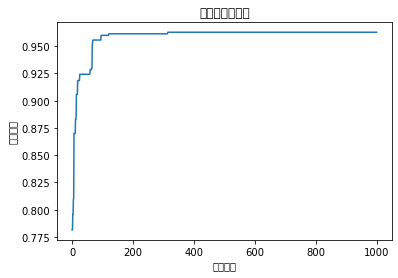

最优值为 0.7814285714285715 最优位置为 [-9.01236872  1.19840032 -1.19562498 ... -5.29102555  5.17382764
 -2.22085979]


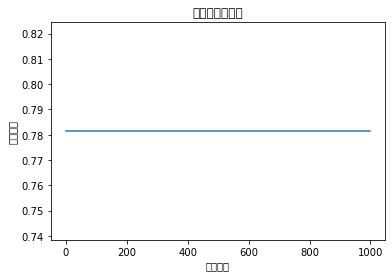

 20%|██        | 2/10 [25:10<1:40:40, 755.08s/it]

最优值为 0.9342857142857143 最优位置为 [ -3.39581583   1.68622059  -0.64344171 ... -11.18099629  14.01962362
   2.93274328]


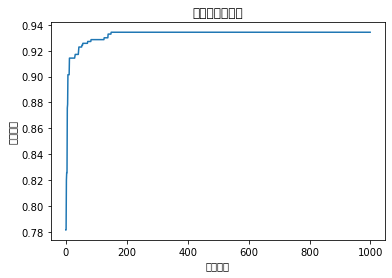

最优值为 0.9542857142857143 最优位置为 [ 0.45387659  0.65602087 -1.00733929 ...  2.0130389   2.21681214
  3.41092002]


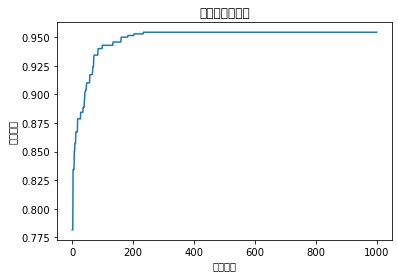

最优值为 0.8514285714285714 最优位置为 [ 0.03651065 -0.01323022 -0.31708217 ... -0.01140591  2.38789204
 -3.92447597]


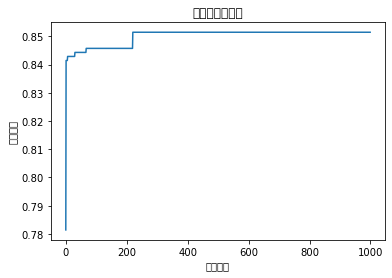

 30%|███       | 3/10 [37:41<1:27:51, 753.10s/it]

最优值为 0.9485714285714286 最优位置为 [ -3.65027798   0.67715167  -3.63975377 ... -21.85503163  62.62853944
  31.60027767]


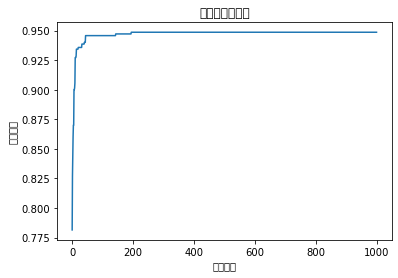

最优值为 0.9471428571428572 最优位置为 [ 0.38109025  1.67169435 -0.00556474 ... -2.84643028  2.25413738
  0.20276684]


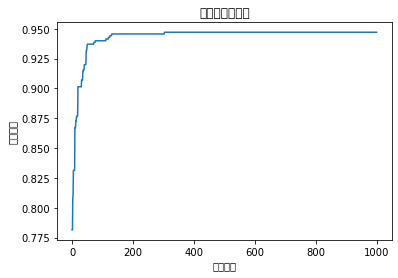

最优值为 0.8142857142857143 最优位置为 [ 2.49312346e-04 -1.59822779e-03  2.44128645e-02 ... -1.14059129e-02
  2.38789204e+00 -3.92447597e+00]


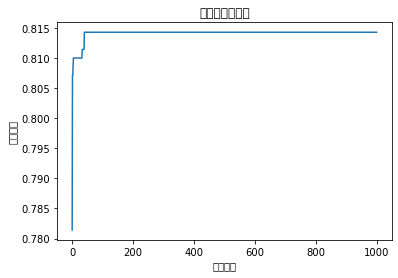

 40%|████      | 4/10 [50:36<1:16:12, 762.06s/it]

最优值为 0.8957142857142857 最优位置为 [ -0.39615328   3.58822617  -3.50390821 ... -15.22313488  39.73942329
  10.72132468]


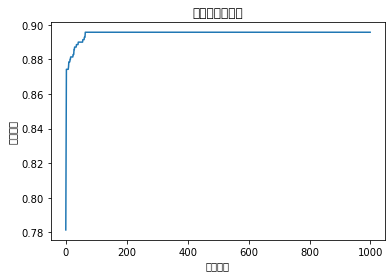

最优值为 0.9814285714285714 最优位置为 [ 4.61297933  0.05064628  0.45170214 ... -3.97574974  2.24589861
 -3.7181749 ]


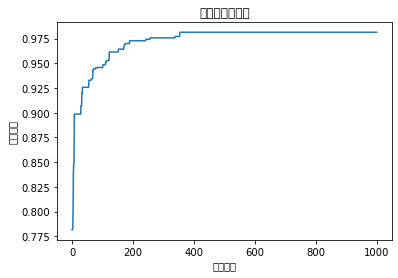

最优值为 0.8357142857142857 最优位置为 [ 4.90268333  0.02009336 -0.06624901 ...  3.14586561 -2.1461357
  3.49895956]


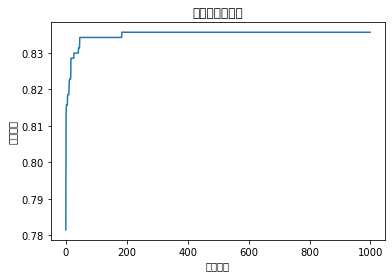

 50%|█████     | 5/10 [1:03:09<1:03:12, 758.57s/it]

最优值为 0.8971428571428571 最优位置为 [ -0.16611157   0.89042809  -1.65314517 ... -22.73634146  16.53040405
  -5.65982023]


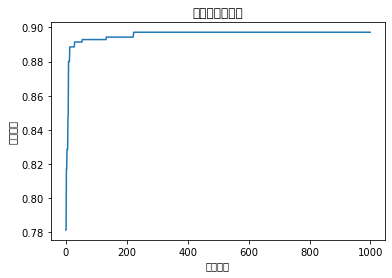

最优值为 0.97 最优位置为 [ 3.90816757  0.82244577 -4.30755307 ...  2.36429565  1.14276192
 -0.29437411]


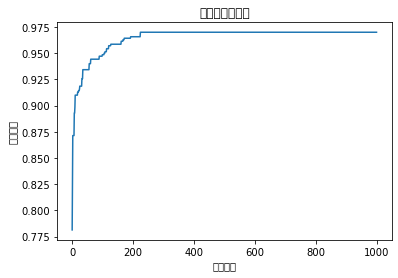

最优值为 0.85 最优位置为 [ 0.05955401 -0.72204081 -0.02069133 ... -2.37632888 -1.87910111
  2.22573289]


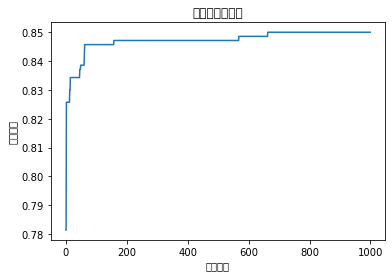

 60%|██████    | 6/10 [1:15:33<50:14, 753.70s/it]  

最优值为 0.9128571428571428 最优位置为 [-2.5547329   0.57900377 -0.26988397 ... -4.26964652  6.8264862
 -2.36356562]


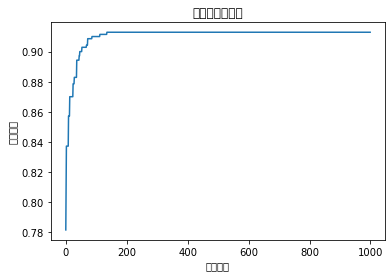

最优值为 0.97 最优位置为 [ 0.03436163 -0.00181078 -0.01819821 ...  0.05232005  0.92790076
  0.13283445]


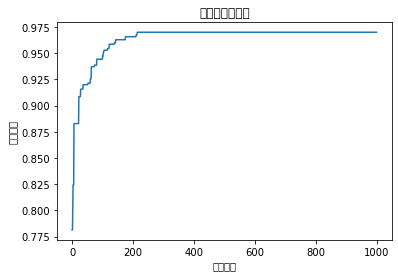

最优值为 0.7814285714285715 最优位置为 [-9.01236872  1.19840032 -1.19562498 ... -5.29102555  5.17382764
 -2.22085979]


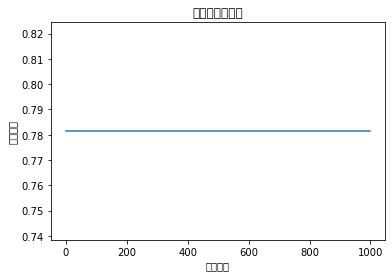

 70%|███████   | 7/10 [1:27:45<37:20, 746.73s/it]

最优值为 0.8928571428571429 最优位置为 [-3.66760718 -0.1836342   1.32933097 ... -7.12185513  2.36294327
 -2.77720115]


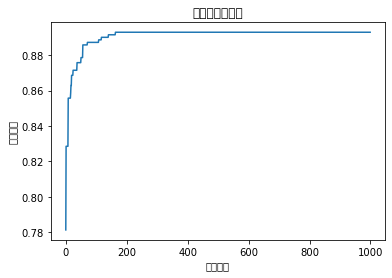

最优值为 0.9057142857142857 最优位置为 [ 0.49197482 -0.07175766 -0.1021547  ... -1.56151243 -1.88085415
 -0.3825895 ]


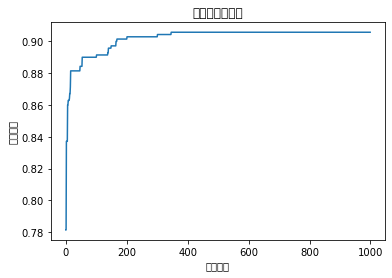

最优值为 0.7814285714285715 最优位置为 [-9.01236872  1.19840032 -1.19562498 ... -5.29102555  5.17382764
 -2.22085979]


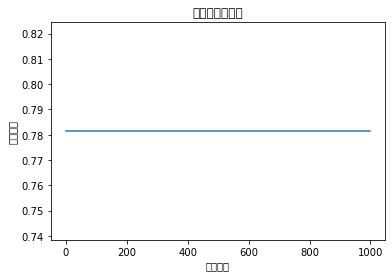

 80%|████████  | 8/10 [1:39:55<24:42, 741.14s/it]

最优值为 0.9214285714285714 最优位置为 [  -1.48322535    1.15307757   -2.45930099 ... -298.06883483  655.60387497
 -208.69127589]


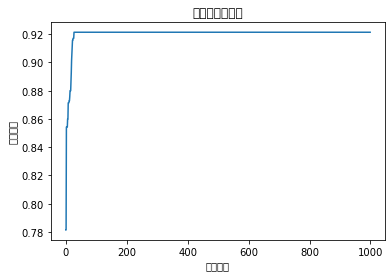

最优值为 0.93 最优位置为 [ 0.34139137  0.57099718 -0.03276022 ... -1.48275314  3.41907939
  0.75289434]


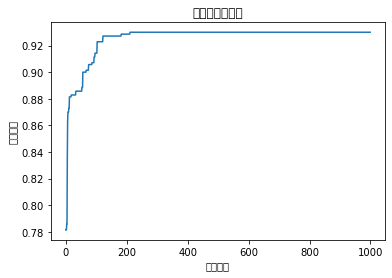

最优值为 0.7914285714285715 最优位置为 [ 1.85244012  0.83004606  0.47022251 ...  4.46529427 -2.54980471
 -3.81365285]


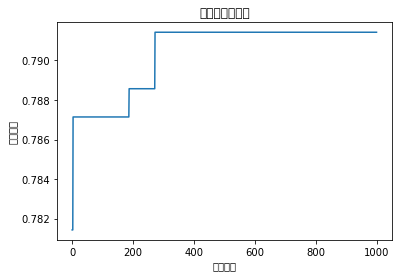

 90%|█████████ | 9/10 [1:52:45<12:30, 750.24s/it]

最优值为 0.9185714285714286 最优位置为 [  1.69347109  -0.51637971   0.42779999 ... -10.16757406  33.45004178
  -2.10941856]


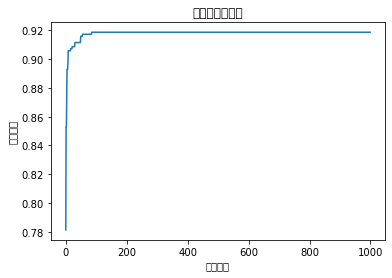

最优值为 0.9571428571428572 最优位置为 [ 0.08889379 -0.0506773   0.10833581 ... -0.8156153   2.21607228
 -4.27874418]


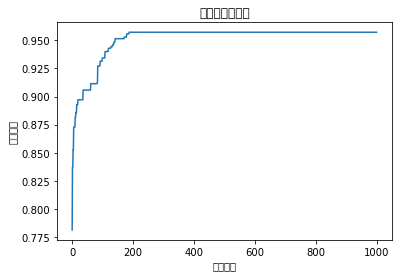

最优值为 0.7928571428571428 最优位置为 [ 0.07626981  0.02695323 -0.17117886 ... -0.01140591  2.38789204
 -3.92447597]


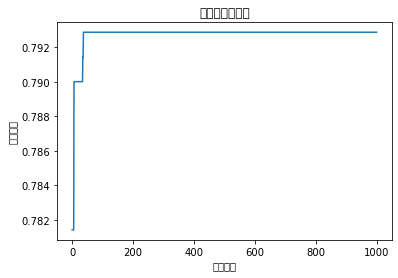

100%|██████████| 10/10 [2:05:17<00:00, 751.71s/it]


In [92]:
accuracy1 = np.zeros(4)
accuracy2 = np.zeros(4)
initial_weights = []
initial_velocities = []
for curr_sol in np.arange(0, N):
    w1 = np.random.normal(0, 4, size=(input_shape, 2*input_shape))
    w2 = np.random.normal(0, 4, size=(2*input_shape, 1))
    v1 = np.random.normal(0, 1, size=(input_shape, 2*input_shape))
    v2 = np.random.normal(0, 1, size=(2*input_shape, 1))
    initial_weights.append(np.array([w1, w2]))
    initial_velocities.append(np.array([v1, v2]))

gb_pso = np.ones([10,T])
gbt_pso = np.ones([10,T])
pso_best = np.ones([10,2*input_shape*(input_shape+1)])

gb_cso = np.ones([10,T])
gbt_cso = np.ones([10,T])
cso_best = np.ones([10,2*input_shape*(input_shape+1)])
    
gb_scso = np.ones([10,T])
gbt_scso = np.ones([10,T])
scso_best = np.ones([10,2*input_shape*(input_shape+1)])
    

for generation in tqdm(range(10)):
    weights = np.array(initial_weights)
    velocities = np.array(initial_velocities)
    
    
    #pso
    x1 = mat_to_vector(weights)
    v1 = mat_to_vector(velocities)
    p1 = x1
    p1_best = fitness(np.array(dataset1), np.array(labelset1), weights, activation=sigmoid)
    g1_best = 0
    
    pso_best[generation] = x1[0]
    
    for i in range(T):
        for j in range(N):
            pre, _ = predict(np.array(dataset1), np.array(labelset1), weight_vector_to_mat(x1[j,:], weights[0]), sigmoid)
            if p1_best[j] < pre:
                p1_best[j] = pre
                p1[j,:] = x1[j,:].copy()
            if g1_best < p1_best[j]:
                g1_best = p1_best[j]
                pso_best[generation] = x1[j,:].copy()
            w = w_max - (w_max - w_min) * i / T
            
            v1[j, :] = w * v1[j, :] + c1 * np.random.rand(1) * (p1[j, :] - x1[j, :]) + c2 * np.random.rand(1) * (pso_best[generation] - x1[j, :])
            x1[j, :] = x1[j, :] + v1[j, :]
            
            for ii in range(pso_best.shape[0]):
                if (v1[j, ii] > v_max) or (v1[j, ii] < v_min):
                    v1[j, ii] = v_min + np.random.rand(1) * (v_max - v_min)
                if (x1[j, ii] > x_max) or (x1[j, ii] < x_min):
                    x1[j, ii] = x_min + np.random.rand(1) * (x_max - x_min)
        
        gb_pso[generation,i] = g1_best
        gbt_pso[generation,i], _ = predict(np.array(dataset2), np.array(labelset2), weight_vector_to_mat(pso_best[generation], weights[0]), sigmoid)


    #cso
    x2 = mat_to_vector(weights)
    v2 = mat_to_vector(velocities)
    f2 = np.zeros(N) 
    for i in range(N):
        if np.random.random() < mix_ratio:
            f2[i] = 1
    p2 = x2
    p2_best = fitness(np.array(dataset1), np.array(labelset1), weights, activation=sigmoid)
    g2_best = 0

    cso_best[generation] = x2[0]
    
    for i in range(T):
        for j in range(N):
            pre, _ = predict(np.array(dataset1), np.array(labelset1), weight_vector_to_mat(x2[j,:], weights[0]), sigmoid)
            if p2_best[j] < pre:
                p2_best[j] = pre
                p2[j,:] = x2[j,:].copy()
            if g2_best < p2_best[j]:
                g2_best = p2_best[j]
                cso_best[generation] = x2[j,:].copy()
            # tracing_mode
            if f2[j]:
                w = w_max - (w_max - w_min) * i / T
                v2[j, :] = w * v2[j, :] + c2 * np.random.rand(1) * (cso_best[generation] - x2[j, :])
                x2[j, :] = x2[j, :] + v2[j, :]
            #seeking_mode
            else:
                pool = []
                fit = np.zeros(smp)
                clones = [x2[j,:].copy() for _ in range(smp)]
                count = 0
                for clone in clones:
                    idx = np.random.randint(int(cso_best.shape[0]*cdc), size=cso_best[generation].shape[0])
                    for u in idx:
                        if np.random.uniform() < 0.5:
                            clone[u] = (1+srd)*clone[u]
                        else:
                            clone[u] = (1-srd)*clone[u]
                    fit[count], _ = predict(np.array(dataset1), np.array(labelset1), weight_vector_to_mat(clone, weights[0]), sigmoid)
                    pool.append(clone)
                x2[j,:] = pool[roulett(fit)]
            for ii in range(cso_best[generation].shape[0]):
                if (v2[j, ii] > v_max) or (v2[j, ii] < v_min):
                    v2[j, ii] = v_min + np.random.rand(1) * (v_max - v_min)
                if (x2[j, ii] > x_max) or (x2[j, ii] < x_min):
                    x2[j, ii] = x_min + np.random.rand(1) * (x_max - x_min)
            if np.random.random() < mix_ratio:
                f2[j] = 1
            else:
                f2[j] = 0;
        gb_cso[generation,i] = g2_best
        gbt_cso[generation,i], _ = predict(np.array(dataset2), np.array(labelset2), weight_vector_to_mat(cso_best[generation], weights[0]), sigmoid)

    
    #scso
    x3 = mat_to_vector(weights)
    v3 = mat_to_vector(velocities)
    f3 = np.zeros(N) 
    for i in range(N):
        if np.random.random() < mix_ratio:
            f3[i] = 1
    p3 = x3
    p3_best = fitness(np.array(dataset1), np.array(labelset1), weights, activation=sigmoid)
    g3_best = 0

    scso_best[generation] = x[0]
    
    for i in range(T):
        rg = S - (S*i/T)
        for j in range(N):
            r = rg*np.random.rand()
            R = 2*rg*np.random.rand() - rg
            
            pre, _ = predict(np.array(dataset1), np.array(labelset1), weight_vector_to_mat(x3[j,:], weights[0]), sigmoid)
            if p3_best[j] < pre:
                p3_best[j] = pre
                p3[j,:] = x3[j,:].copy()
            if g3_best < p3_best[j]:
                g3_best = p3_best[j]
                scso_best[generation] = x3[j,:].copy()
            for k in range(scso_best.shape[0]):
                teta = np.random.rand()*2*3.14
                #exploitation
                if R <= 1 and R >= -1:
                    rand_pos = abs(np.random.rand()*scso_best[generation,k] -x3[j,k])
                    x3[j,k] = scso_best[generation,k] - r*rand_pos*np.cos(teta)
                #exploratioon
                else:
                    cp = int(np.random.rand() * N)
                    x3[j,k] = r*(p3[j,k] - np.random.rand()*x3[j,k])
            
            for ii in range(scso_best[generation].shape[0]):
                if (v3[j, ii] > v_max) or (v3[j, ii] < v_min):
                    v3[j, ii] = v_min + np.random.rand(1) * (v_max - v_min)
                if (x3[j, ii] > x_max) or (x3[j, ii] < x_min):
                    x3[j, ii] = x_min + np.random.rand(1) * (x_max - x_min)
            if np.random.random() < mix_ratio:
                f3[j] = 1
            else:
                f3[j] = 0;
        gb_scso[generation,i] = g3_best
        gbt_scso[generation,i], _ = predict(np.array(dataset2), np.array(labelset2), weight_vector_to_mat(scso_best[generation], weights[0]), sigmoid)


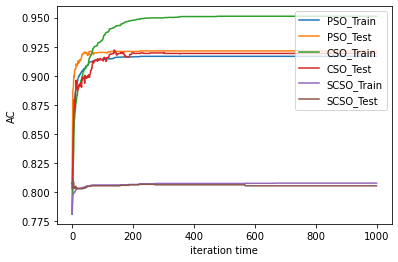

In [104]:
av_pso = gb_pso[0]
av_cso = gb_cso[0]
av_scso = gb_scso[0]
avt_pso = gbt_pso[0]
avt_cso = gbt_cso[0]
avt_scso = gbt_scso[0]
pso_b = pso_best[0]
cso_b = cso_best[0]
scso_b = scso_best[0]
weights = np.array(initial_weights)
pso_pre, _ = predict(np.array(dataset1), np.array(labelset1), weight_vector_to_mat(pso_b, weights[0]), sigmoid)
cso_pre, _ = predict(np.array(dataset1), np.array(labelset1), weight_vector_to_mat(cso_b, weights[0]), sigmoid)
scso_pre, _ = predict(np.array(dataset1), np.array(labelset1), weight_vector_to_mat(scso_b, weights[0]), sigmoid)

for i in range(9):
    av_pso = av_pso + gb_pso[i+1]
    avt_pso = avt_pso + gbt_pso[i+1]
    av_cso = av_cso + gb_cso[i+1]
    avt_cso = avt_cso + gbt_cso[i+1]
    av_scso = av_scso + gb_scso[i+1]
    avt_scso = avt_scso + gbt_scso[i+1]
    p_pre, _ = predict(np.array(dataset1), np.array(labelset1), weight_vector_to_mat(pso_best[i+1], weights[0]), sigmoid)
    c_pre, _ = predict(np.array(dataset1), np.array(labelset1), weight_vector_to_mat(cso_best[i+1], weights[0]), sigmoid)
    sc_pre, _ = predict(np.array(dataset1), np.array(labelset1), weight_vector_to_mat(scso_best[i+1], weights[0]), sigmoid)
    if(pso_pre < p_pre):
        pso_b = pso_best[i+1]
        pso_pre = p_pre
    if(cso_pre < c_pre):
        cso_b = cso_best[i+1]
        cso_pre = c_pre
    if(scso_pre < sc_pre):
        scso_b = scso_best[i+1]
        scso_pre = sc_pre
av_pso = av_pso/10
avt_pso = avt_pso/10
av_cso = av_cso/10
avt_cso = avt_cso/10
av_scso = av_scso/10
avt_scso = avt_scso/10

plt.plot(range(T),av_pso,label = "PSO_Train")
plt.plot(range(T),avt_pso, label = "PSO_Test")
plt.plot(range(T),av_cso, label = "CSO_Train")
plt.plot(range(T),avt_cso, label = "CSO_Test")
plt.plot(range(T),av_scso, label = "SCSO_Train")
plt.plot(range(T),avt_scso, label = "SCSO_Test")
leg = plt.legend(loc="upper right")
plt.xlabel("iteration time")
plt.ylabel("AC")
plt.show()


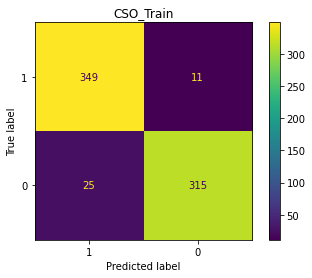

In [140]:
tp, fn, fp, tn = conf_mat(np.array(dataset1), np.array(labelset1), weight_vector_to_mat(pso_b, weights[0]), sigmoid)
cm = np.matrix([[int(tp),int(fp)],[int(fn),int(tn)]])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])  # reverse display labels
dp = disp.plot()
plt.title("CSO_Train")
plt.show()

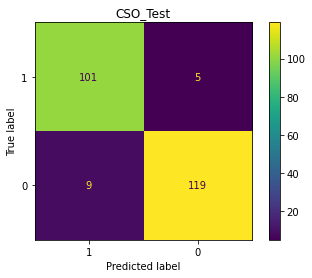

In [144]:
tp, fn, fp, tn = conf_mat(np.array(dataset2), np.array(labelset2), weight_vector_to_mat(cso_b, weights[0]), sigmoid)
cm = np.matrix([[int(tp),int(fp)],[int(fn),int(tn)]])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])  # reverse display labels
dp = disp.plot()
plt.title("CSO_Test")
plt.show()

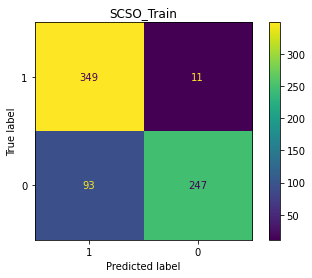

In [142]:
tp, fn, fp, tn = conf_mat(np.array(dataset1), np.array(labelset1), weight_vector_to_mat(scso_b, weights[0]), sigmoid)
cm = np.matrix([[int(tp),int(fp)],[int(fn),int(tn)]])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])  # reverse display labels
dp = disp.plot()
plt.title("SCSO_Train")
plt.show()

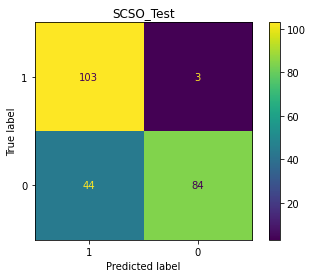

In [143]:
tp, fn, fp, tn = conf_mat(np.array(dataset2), np.array(labelset2), weight_vector_to_mat(scso_b, weights[0]), sigmoid)
cm = np.matrix([[int(tp),int(fp)],[int(fn),int(tn)]])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])  # reverse display labels
dp = disp.plot()
plt.title("SCSO_Test")
plt.show()

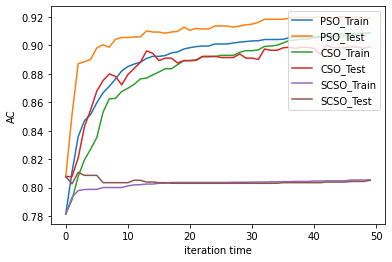

In [145]:
plt.plot(range(50),av_pso[:50],label = "PSO_Train")
plt.plot(range(50),avt_pso[:50], label = "PSO_Test")
plt.plot(range(50),av_cso[:50], label = "CSO_Train")
plt.plot(range(50),avt_cso[:50], label = "CSO_Test")
plt.plot(range(50),av_scso[:50], label = "SCSO_Train")
plt.plot(range(50),avt_scso[:50], label = "SCSO_Test")
leg = plt.legend(loc="upper right")
plt.xlabel("iteration time")
plt.ylabel("AC")
plt.show()